In [1]:
%pylab inline
import gc
import galsim
import numpy as np
import fpfsBase
import astropy.io.fits as pyfits

import numpy.lib.recfunctions as rfn

import fpfsBase

pltDir='plot/errors/'
vdir='outcome-var7em3'
def measure(galImgAll):
    imgList=[galImgAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end] for i in range(ngal)]
    a=fpTask.measure(imgList)
    del imgList
    gc.collect()
    return a

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


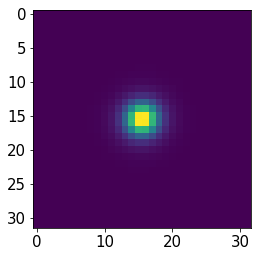

In [3]:
ngrid=64
nx=100;ny=100
ngal=nx*ny
scale=0.168
beta=0.75
psfFWHM=0.60
rcut=16
beg=ngrid//2-rcut
end=beg+2*rcut
# Initialize the fpfsTask
psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
psfImg  =   psfInt.drawImage(nx=64,ny=64,scale=scale)
psfData =   psfImg.array[beg:end,beg:end]
plt.imshow(psfData)
fpTask=fpfsBase.fpfsTask(psfData,beta=beta)

In [4]:
mms=[]
mms2=[]
mmsN=[]
mmsN2=[]
for igroup in range(16):
    # read galaxy image
    galImgAll=pyfits.getdata('galaxy_basic_psf%d/image-%d-g1-1111.fits' %(psfFWHM*100,igroup))
    mm=measure(galImgAll)
    mms.append(mm)
    del mm,galImgAll
    
    galImgAll=pyfits.getdata('galaxy_basic_psf%d/image-%d-g1-1111.fits' %(psfFWHM*100,igroup))
    mm=measure(galImgAll)
    mms2.append(mm)
    del mm,galImgAll
    
for igroup in range(16):
    for ii in range(50):
        ifield=igroup*250+ii
        fname=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-1111.fits' %(igroup,ifield))
        mm=pyfits.getdata(fname)
        mmsN.append(mm)
        del mm,fname
        fname=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-2222.fits' %(igroup,ifield))
        mm=pyfits.getdata(fname)
        mmsN2.append(mm)
        del mm,fname
        gc.collect()
        
mms=rfn.stack_arrays(mms,usemask=False)
mms2=rfn.stack_arrays(mms2,usemask=False)
mmsN=rfn.stack_arrays(mmsN,usemask=False)
mmsN2=rfn.stack_arrays(mmsN2,usemask=False)

In [5]:
C=2000.
b=fpfsBase.fpfsM2E(mms,C)
b2=fpfsBase.fpfsM2E(mms2,C)
bN=fpfsBase.fpfsM2E(mmsN,C,rev=True)
bN2=fpfsBase.fpfsM2E(mmsN2,C,rev=True)
cN=fpfsBase.fpfsM2Err(mmsN,C)
cN2=fpfsBase.fpfsM2Err(mmsN2,C)

In [6]:
mask=(b['fpfs_s0']>0.1)
maskN=(bN['fpfs_s0']>0.1)

print(np.average(bN[maskN]['fpfs_e1'])-np.average(b[mask]['fpfs_e1']))
print(np.average(bN[maskN]['fpfs_e2'])-np.average(b[mask]['fpfs_e2']))
print(np.average(b[mask]['fpfs_e1'])/np.average(b[mask]['fpfs_RE']))
print(np.average(bN[maskN]['fpfs_e1'])/np.average(bN[maskN]['fpfs_RE']))
print(np.average(b[mask]['fpfs_e2'])/np.average(b[mask]['fpfs_RE']))
print(np.average(bN[maskN]['fpfs_e2'])/np.average(bN[maskN]['fpfs_RE']))

4.064246538270578e-05
-4.545094716451054e-05
4.780248572270686e-06
0.0001907089041417312
-2.043272187862747e-06
-0.00020996658747772078


In [7]:
print(np.average(cN['fpfs_e1Err']))
print(np.average(cN['fpfs_e2Err']))
print(np.average(cN['fpfs_s0Err']))
print(np.average(cN['fpfs_e1s0Cov']))
print(np.average(cN['fpfs_e2s0Cov']))

0.000724865874570801
0.0007041878148790826
9.063410186238716e-05
3.3866499341315387e-06
-3.033430320198431e-06


0.013212824380568294


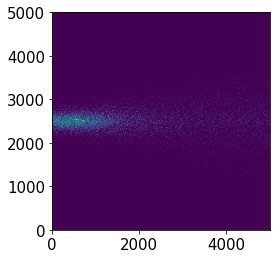

In [8]:
hist,ebins,sbins=np.histogram2d(bN['fpfs_e1'],bN['fpfs_RE'],range=((-0.6,0.6),(-0.,0.5)),bins=(5000,5000))
ePix=ebins[1]-ebins[0]
sPix=sbins[1]-sbins[0]
sCenter,eCenter=np.meshgrid((sbins[:-1]+sbins[1:])/2.,(ebins[:-1]+ebins[1:])/2.)
plt.imshow(hist,origin='lower')
sigma_x = np.sqrt(np.average(cN['fpfs_s0Err']))/sPix
sigma_y = np.sqrt(np.average(cN['fpfs_e1Err']))/ePix
rho=np.average(cN['fpfs_e1s0Cov'])/sigma_x/sigma_y/sPix/ePix
print(rho)

In [9]:
np.average(cN['fpfs_e1s0Cov'])

3.3866499341315387e-06

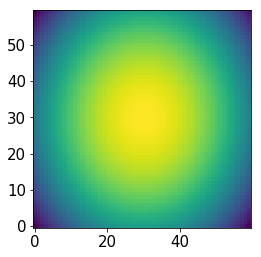

In [10]:
size = 200
nx=len(sbins)-1
ny=len(ebins)-1
x=np.array([np.fft.fftfreq(nx)*nx])
y=np.fft.fftfreq(ny)*ny
y=np.transpose(np.array([y]))
psf  = 1./(2*np.pi*sigma_x*sigma_y)*np.exp(-(x**2/(2*sigma_x**2)-2.*rho*x*y/sigma_x/sigma_y/2. + y**2/(2*sigma_y**2)))
test=np.zeros(psf.shape)
test[150,150]=1.
test2=np.real(np.fft.ifft2(np.fft.fft2(test)*np.fft.fft2(psf)))
plt.imshow(test2[120:180,120:180],origin='lower')
hist2=np.real(np.fft.ifft2(np.fft.fft2(hist)*np.fft.fft2(psf)))

In [14]:
msk=sCenter>0.1
#print((np.sum(eCenter[msk]*hist2[msk])/np.sum(hist2[msk])))
#print((np.sum(eCenter[msk]*hist[msk])/np.sum(hist[msk])))
print((np.sum(eCenter[msk]*hist2[msk])/np.sum(hist2[msk])-np.sum(eCenter[msk]*hist[msk])/np.sum(hist[msk])))

1.99801972612146e-05


In [15]:
mskA=bN['fpfs_s0']>0.1
np.average(bN['fpfs_e1'][mskA])

4.168832528797333e-05

In [13]:
mskA=b['fpfs_s0']>0.10
np.average(b['fpfs_e1'][mskA])

1.045859905267544e-06